In [1]:
import time
import torch

from torch import nn, Tensor
from torch.utils.data import DataLoader, TensorDataset

import flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from flow_matching.utils import ModelWrapper
from Distributions2 import *
# visualization
import matplotlib.pyplot as plt
from models.model_configs import instantiate_model
from matplotlib import cm
from flow import build_ttf_m
from network import MLP,MLP_TailParam,MLP_TailParam2,MLP2,BigTimeConditionalNet,TimeToVecNet,FullConnectedScoreModel,FullConnectedScoreModel_time
from torch.autograd.functional import jacobian
from torch.distributions import Independent, Normal
from extreme_transforms import TailAffineMarginalTransform_SeparateNetParam2
from scaler_grad_vanilla import NativeScalerWithGradNormCount as NativeScaler
# To avoide meshgrid warning
import warnings


warnings.filterwarnings("ignore", category=UserWarning, module='torch')

In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')
torch.manual_seed(42)
seed=42

Using gpu


## Sampling data

In [3]:
import numpy as np

def train_test_split(data, test_ratio=0.5, seed=None):
    """
    Splits BxD data into train and test sets in a 9:1 ratio by default.

    Args:
        data (np.ndarray): Input array of shape (B, D).
        test_ratio (float): Proportion of the data to use for the test set.
        seed (int, optional): Random seed for reproducibility.

    Returns:
        train_data (np.ndarray), test_data (np.ndarray)
    """
    if seed is not None:
        np.random.seed(seed)
    
    B = data.shape[0]
    indices = np.random.permutation(B)
    test_size = int(B * test_ratio)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    
    return data[train_indices], data[test_indices]


In [4]:
Dataset="studentT"#studentT,Cone,pareto,Bike,queue,stock,gmm
option="simpletail"
option_model='simplemodel'

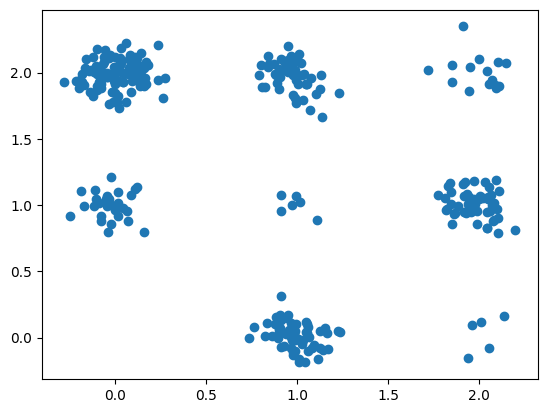

In [5]:
from distribution_DLIM import sample_grid_gmm
import matplotlib.pyplot as plt

weight=[
        0.01,
        0.1,
        0.3,
        0.2,
        0.02,
        0.15,
        0.02,
        0.15,
        0.05
    ]
d=sample_grid_gmm(320,1.7,3,0.1,3,weight,'cpu',False,True,False,1)

plt.scatter(d[:,0],d[:,1])


In [ ]:
#PRINT MIX OF STUDENT-T
from generate_splits import generate_data_split
if Dataset=="studentT":
    dof_og=1
    n_hidden_layers=2
    full_data,objectz=samplestudentT_4(50,dof_og,24000) #40000 x 2
    Data_Splt=generate_data_split('gppg', seed, 'dummy',full_data)
    trn_ix = Data_Splt["split"]["trn"]
    tst_ix = Data_Splt["split"]["tst"]
    full_data_train =full_data[trn_ix]   
    full_data_test =full_data[tst_ix] 
    x_lim=y_lim=80
    iterations=1600
    hidden_dim=512
    # full_data_train,full_data_test=train_test_split(full_data,seed=seed,test_ratio=0.5)
    dimension=2
elif Dataset=="pareto":
    iterations=800*4
    dimension=20
    full_data = np.load('c:\\Users\\adity\\OneDrive\\Desktop\\mscThesis\\Code3\\Thesis_FLow\\heavy_tail_diffusion-main\\data\\pareto\\pareto_20d_data.npy').reshape(-1,20)[0:30000,0:dimension] #(100000, 20)
    full_data_train,full_data_test=train_test_split(full_data,seed=seed)
    print(full_data_train.shape)
    hidden_dim=256
    n_hidden_layers=2
    x_lim=y_lim=8
elif Dataset=='Cone':
    pass
elif Dataset=='queue':
    dimension=20
    full_data = np.load('c:\\Users\\adity\\OneDrive\\Desktop\\mscThesis\\Code3\\Thesis_FLow\\heavy_tail_diffusion-main\\data\\queue\\queue_data_20d.npy')[0:90000,0,0:dimension]
    full_data_train,full_data_test=train_test_split(full_data,seed=seed)
    
    print(full_data_train.shape)
    x_lim=y_lim=200
    iterations=1200
    hidden_dim=256  #128 for 12
    n_hidden_layers=6
elif Dataset=="Stock":
    full_data_train = np.load('c:\\Users\\adity\\OneDrive\\Desktop\\mscThesis\\Code3\\Thesis_FLow\\heavy_tail_diffusion-main\\data\\stock\\stock_data_train_20.npy').reshape(-1,20)# 1200,20
    full_data_test = np.load('c:\\Users\\adity\\OneDrive\\Desktop\\mscThesis\\Code3\\Thesis_FLow\\heavy_tail_diffusion-main\\data\\stock\\stock_data_test_20.npy').reshape(-1,20)# 282,20

    dimension=20
    print(full_data_train.shape)
    x_lim=y_lim=20
    iterations=1800
    hidden_dim=128
    n_hidden_layers=2
elif Dataset=='gmm':
    full_data=sample_grid_gmm(320,1.7,3,0.1,3,weight,'cpu',False,True,False,1)
    dimension=2
    full_data_train,full_data_test=train_test_split(full_data,seed=seed)
    x_lim=y_lim=200
    iterations=500
    hidden_dim=128

    




100%|██████████| 2/2 [00:43<00:00, 21.91s/it]


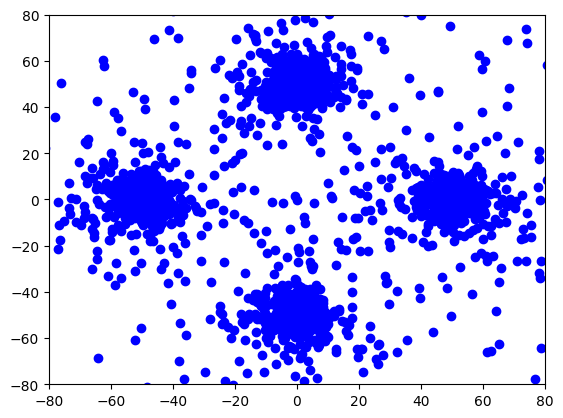

In [7]:
plt.ylim((-1*y_lim,y_lim))
plt.xlim((-1*x_lim,x_lim))
plt.scatter(full_data_train[:,0],full_data_train[:,1],c="blue")


In [8]:
full_data_train.shape

torch.Size([9600, 2])

## Building the  Model

In [9]:
dimension


2

In [10]:
if option_model=='simplemodel':
    print("simplemodel")
    # model=BigTimeConditionalNet(input_dim=dimension, time_dim=dimension, hidden_dim=hidden_dim).to(device)
    # model=MLP2(input_dim=dimension, time_dim=1, hidden_dim=hidden_dim).to(device) #PREVECTOR FIELD
    model=MLP(input_dim=dimension, time_dim=1, hidden_dim=hidden_dim).to(device) 
    # model=FullConnectedScoreModel(dimension,hidden_dim,n_hidden_layers).to(device)
else:
    model = instantiate_model(
        architechture='studentT',
        is_discrete=False,
        use_ema=True,
    ).to(device)


if option=='simpletail':
    # Tail_paramNet=TimeToVecNet(1,hidden_dim,4*dimension).to(device)
    Tail_paramNet=MLP_TailParam2(time_dim=1, hidden_dim=hidden_dim//2,output_dim=4*dimension).to(device) #LAMBDA +,- , MEAN , SCALE 

    # Tail_paramNet=MLP_TailParam2(time_dim=1, hidden_dim=hidden_dim//2,output_dim=4*dimension).to(device) #LAMBDA +,- , MEAN , SCALE #PARETO
    # Tail_paramNet=FullConnectedScoreModel_time(dimension,hidden_dim//2,n_hidden_layers//2).to(device)
    print("simple")
else:
    Tail_paramNet=instantiate_model(
    architechture=Dataset+'_tail',   #CHANGE MAYBE
    is_discrete=False,
    use_ema=True,
        ).to(device)
noise2data=TailAffineMarginalTransform_SeparateNetParam2(dimz=dimension).to(device)  


simplemodel
simple


In [11]:
# model(torch.randn(5,1,20),torch.randn(5),extra=[]).shape,Tail_paramNet(torch.randn(5,1,20),torch.randn(5),extra=[]).shape

In [12]:
# noise2data(torch.zeros(6,2),torch.zeros(6,8)).shape

In [ ]:
lr = 0.0001
batch_size = 4096
print_every = 10


In [14]:
train_dataset = TensorDataset(torch.tensor(full_data_train))


# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

C:\Users\adity\AppData\Local\Temp\ipykernel_13448\4294779823.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(full_data_train))


In [15]:
jo=0 #counter
path = AffineProbPath(scheduler=CondOTScheduler())


optim = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=1e-3)
optim2=torch.optim.Adam(Tail_paramNet.parameters(), lr=lr,weight_decay=1e-3)#,weight_decay=1e-3)
loss_scaler = NativeScaler()
# scheduler = torch.optim.lr_scheduler.LinearLR(optim, start_factor=lr, end_factor=0.0, total_iters=iterations*len(train_loader))
# scheduler2 = torch.optim.lr_scheduler.LinearLR(optim2, start_factor=lr, end_factor=0.0, total_iters=iterations*len(train_loader))



c:\Users\adity\OneDrive\Desktop\mscThesis\Code3\Thesis_FLow\scaler_grad_vanilla.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self._scaler = torch.cuda.amp.GradScaler()


In [16]:
dim=dimension
dimx=dimension

In [ ]:

# train
start_time = time.time()
for i in range(iterations):
    for data in train_loader:
        optim.zero_grad()
        optim2.zero_grad()

        x_1=data[0].float().to(device)   #batch x 20
        x_0 = torch.randn_like(x_1).float().to(device) #batch x 20

        # print("x_shape",x_0.shape,x_1.shape,x_1.mean())

        if i<(3*iterations)//4:
            t = 1-torch.sqrt(1-torch.rand(x_1.shape[0])).to(device) #best
        else:
            t= -torch.log(1 - torch.rand(x_1.shape[0]) * (1 - torch.exp(torch.tensor(-1)))).to(device)

        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
        x_t,time_t,dx_t=path_sample.x_t,path_sample.t,path_sample.dx_t  #x_t- B X 20
        # print("x_t",x_t.shape)

        if option_model=='simplemodel':
            prefinal_vf=model(x_t,time_t)
        else:
            prefinal_vf=model(x_t.unsqueeze(1),time_t,extra=[])  #B X 1 X 20
        # print(prefinal_vf.shape)
        prefinal_vf=prefinal_vf.reshape(prefinal_vf.shape[0],-1) #B X 20
        # print("hello",prefinal_vf.shape)






        velocity_field=prefinal_vf

        
        loss = torch.pow( velocity_field - dx_t, 2).mean()#/(0.001+torch.abs(dx_t.max()))# remove the max division for math correct
        print(velocity_field.max(),dx_t.max(),loss)

        loss_scaler(
            loss,
            optim,
            optim2,
            parameters=model.parameters(),
            parameters2=Tail_paramNet.parameters(),
            update_grad=True,
            )      
        # scheduler.step()
        # scheduler2.step()

    # log loss
        jo=jo+1
        if (jo+1) % print_every == 0:
            elapsed = time.time() - start_time
            print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} '
                .format(jo+1, elapsed*1000/print_every, loss.item()))
            start_time = time.time()

tensor(4.3764, device='cuda:0', grad_fn=<MaxBackward1>) tensor(5074.1763, device='cuda:0') tensor(9103.8984, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.8847, device='cuda:0', grad_fn=<MaxBackward1>) tensor(61369.4531, device='cuda:0') tensor(2674473.7500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(37.9592, device='cuda:0', grad_fn=<MaxBackward1>) tensor(61371.4258, device='cuda:0') tensor(464383.3438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.8273, device='cuda:0', grad_fn=<MaxBackward1>) tensor(232.2301, device='cuda:0') tensor(12502.8750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(38.4514, device='cuda:0', grad_fn=<MaxBackward1>) tensor(61373.7422, device='cuda:0') tensor(464678.8750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.2975, device='cuda:0', grad_fn=<MaxBackward1>) tensor(3258.8347, device='cuda:0') tensor(10624.1846, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(571.6661, device='cuda:0', grad_fn=<MaxBackward1>) tensor(61371.1172, devi

In [ ]:
28*len(train_loader)

56

In [ ]:
1200/2000

0.6

In [ ]:
model.eval()
Tail_paramNet.eval()

MLP_TailParam2(
  (main): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): Swish()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Swish()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): Swish()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): Swish()
    (8): Linear(in_features=16, out_features=8, bias=True)
  )
)

In [ ]:
# torch.save(Tail_paramNet.state_dict(), 'tailmodelv3.pth')
# torch.save(vf.state_dict(),"modelv3.pth")

In [ ]:
class combined(nn.Module):
    def __init__(
        self,tail_param_net,PreVFnet,NOISE2DATA
    ):
        # self.features = features
        super(combined, self).__init__()
        self.tail_param_net=tail_param_net
        self.PreVFnet=PreVFnet
        self.NOISE2DATA=NOISE2DATA
    def forward(self, x_t,time_t):
        time_t=time_t.reshape(-1).expand(x_t.shape[0])
        lol=None

        if option_model=='simplemodel':
            prefinal_vf=self.PreVFnet(x_t,time_t)
        else:
            prefinal_vf=self.PreVFnet(x_t.unsqueeze(1),time_t,extra=[])
        prefinal_vf=prefinal_vf.reshape(prefinal_vf.shape[0],-1)
        


        velocity_field=prefinal_vf

        return(velocity_field)
        


In [ ]:
Combo=combined(Tail_paramNet,model,noise2data)
# print(a)
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)

# print(a)
wrapped_vf = WrappedModel(Combo)

In [ ]:
list(wrapped_vf.parameters())
a,b=torch.rand(1,dimension),torch.rand(1)
# print(z)
# Tail_paramNet(b.unsqueeze(1).to(device))
Combo(a.to(device),b.to(device))

tensor([[2.1898, 1.5635]], device='cuda:0', grad_fn=<ViewBackward0>)

In [ ]:
# step size for ode solver
step_size = 0.05

norm = cm.colors.Normalize(vmax=50, vmin=0)

batch_size = full_data_test.shape[0]  # batch size
eps_time = 1e-2
T = torch.linspace(0,1,10)  # sample times
T = T.to(device=device)
# print(a)

x_init = torch.randn((batch_size, dimension), dtype=torch.float32, device=device)
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class
sol = solver.sample(time_grid=T, x_init=x_init, method='midpoint', step_size=step_size, return_intermediates=True)  # sample from the model


In [ ]:
# print(sol)
# sol[0,:,0]=x_tst
x_tst=full_data_test


sol = sol.cpu().numpy()
T = T.cpu()


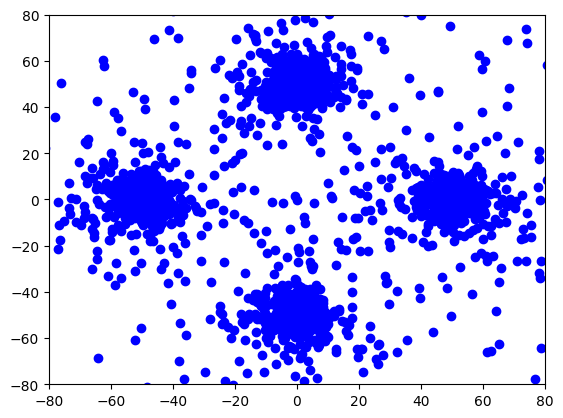

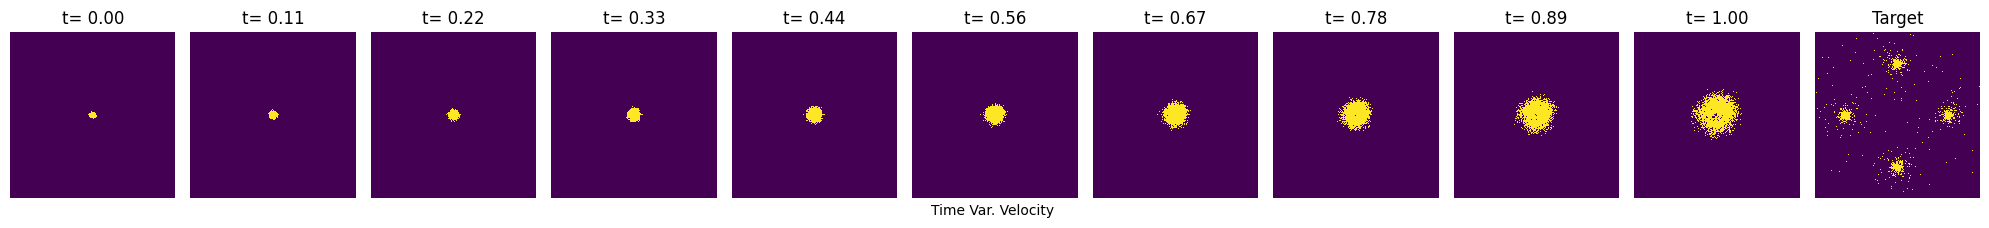

In [ ]:

RR=x_lim
fig, axs = plt.subplots(1, 11,figsize=(20,20))

for i in range(11):
    # if i==10:
    #     H = axs[i].hist2d(x_tst[:,0], x_tst[:,1], 300, range=((-1*RR,RR), (-1*RR,RR)), norm=norm)
    # else:
    #     H= axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-1*RR,RR), (-1*RR,RR)), norm=norm)

    cmin = 0.0
    cmax = 0.99#torch.quantile(torch.from_numpy(H[0]), 0.99).item()

    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
    if i==10:
        _ = axs[i].hist2d(x_tst[:,0], x_tst[:,1], 300, range=((-1*RR,RR), (-1*RR,RR)), norm=norm)
    else:
        _ = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-1*RR,RR), (-1*RR,RR)), norm=norm)

    axs[i].set_aspect('equal')
    axs[i].axis('off')
    if i==10:
        axs[i].set_title('Target')
    else:

        axs[i].set_title('t= %.2f' % (T[i]))

plt.tight_layout()
fig.text(0.5, 0.45, 'Time Var. Velocity ', ha='center')
plt.show()

In [ ]:
full_data_test
generated_data=sol[9]

In [ ]:
# sample with likelihood

T = torch.tensor([1., 0.])  # sample times
T = T.to(device=device)

# grid_size = 200
# x_1 = torch.meshgrid(torch.linspace(-60, 60, grid_size), torch.linspace(-60, 60, grid_size))
# x_1 = torch.stack([x_1[0].flatten(), x_1[1].flatten()], dim=1).to(device)
x_1=torch.tensor(x_tst)[0:1000,:].to(device).float()
print(x_1.shape)

torch.Size([1000, 2])


C:\Users\adity\AppData\Local\Temp\ipykernel_13920\405170638.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_1=torch.tensor(x_tst)[0:1000,:].to(device).float()


In [ ]:
plt.scatter(full_data_test[:,0],full_data_test[:,1])
plt.ylim((-1*y_lim,y_lim))
plt.xlim((-x_lim,x_lim))

(-80.0, 80.0)

In [ ]:
plt.scatter(generated_data[:,0],generated_data[:,1])
plt.ylim((-1*y_lim,y_lim))
plt.xlim((-x_lim,x_lim))

(-80.0, 80.0)

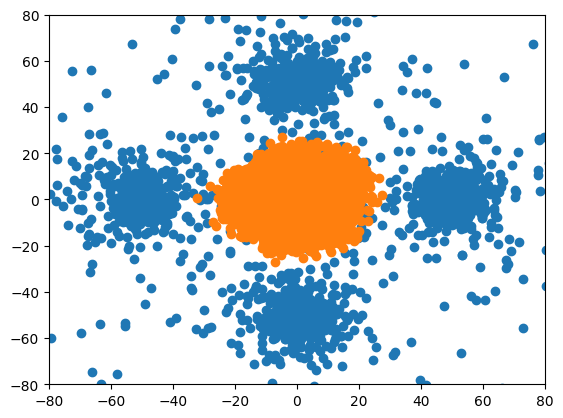

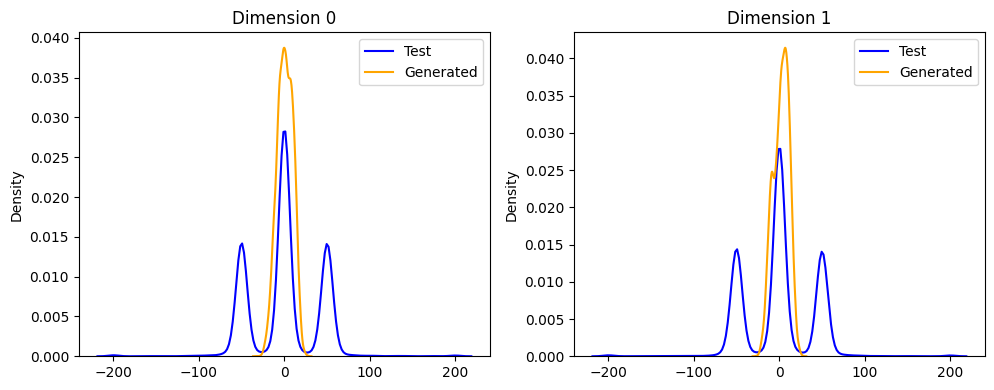

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_kde_subplots(test_data, gen_data, n_cols=3, figsize=(15, 4), suptitle=None):
    """
    Plots KDE comparisons between test and generated data for each dimension.

    Parameters:
    - test_data: np.ndarray of shape (batch, dim)
    - gen_data: np.ndarray of shape (batch, dim)
    - n_cols: Number of columns in subplot grid
    - figsize: Tuple (width, height) for each subplot row
    - suptitle: Optional super title for the figure
    """
    assert test_data.shape == gen_data.shape, "test_data and gen_data must have the same shape"
    
    batch, dim = test_data.shape
    n_rows = (dim + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0], figsize[1]*n_rows))
    axes = axes.flatten()

    for i in range(dim):
        ax = axes[i]
        sns.kdeplot(np.clip(test_data[:, i],-200,200), ax=ax, label='Test', color='blue')
        sns.kdeplot(np.clip(gen_data[:, i],-200,200), ax=ax, label='Generated', color='orange')
        ax.set_title(f'Dimension {i}')
        ax.legend()

    # Remove unused axes
    for j in range(dim, len(axes)):
        fig.delaxes(axes[j])

    if suptitle:
        plt.suptitle(suptitle, fontsize=16)
        plt.subplots_adjust(top=0.92)

    plt.tight_layout()
    plt.show()

plot_kde_subplots(full_data_test,generated_data)

In [ ]:
# source distribution is an isotropic gaussian
gaussian_log_density = Independent(Normal(torch.zeros(dimension, device=device), torch.ones(dimension, device=device)), 1).log_prob

# compute log likelihood with unbiased hutchinson estimator, average over num_acc
num_acc = 10
log_p_acc = 0

for i in range(num_acc):
    _, log_p = solver.compute_likelihood(x_1=x_1, method='midpoint', step_size=step_size, exact_divergence=False, log_p0=gaussian_log_density)
    log_p_acc += log_p
    print(log_p)

log_p_acc /= num_acc

# compute with exact divergence
# _, exact_log_p = solver.compute_likelihood(x_1=x_1, method='midpoint', step_size=step_size, exact_divergence=True, log_p0=gaussian_log_density)

tensor([  -32.1528,   -45.9261,   -40.8486,   -53.2445,   -77.1144,   -34.4062,
          -44.3940,   -41.2905,   -40.0300,   -43.1822,   -44.2012,   -40.0733,
          -39.9086,   -28.3152,   -34.1559,   -45.3617,   -43.2304,   -36.7935,
          -42.5157,   -31.7002,   -30.8723,   -61.6062,   -43.8262,   -36.1901,
          -45.2262,   -27.8505,   -36.1424,   -42.2374,   -42.3339,   -42.6840,
          -22.2813,   -30.5900,   -30.8267,   -43.8796,   -33.3057,   -41.3944,
          -40.9416,   -29.0474,   -43.8709,   -56.5998,   -44.6699,   -43.1438,
          -36.7578,   -40.6044,   -46.2568,   -39.5957,   -31.9995,   -34.4679,
          -29.4133,   -44.3388,   -40.5260,   -45.0833,   -11.5302,   -39.0009,
          -44.9416,   -41.7789,   -11.2971,   -41.8718,   -32.8481,   -37.2682,
          -41.6085,   -43.0566,   -44.6211,   -43.5631,   -45.1721,   -31.5925,
          -42.7242,   -37.1542,   -32.6163,   -52.9178,   -40.6823,   -30.3306,
          -27.8208,   -39.6470,   -27.26

In [ ]:
print(log_p_acc.mean())  #    queueu=-14
#-3725 rms
# -99 rms
#-14 rms
#-63 adam
#-59.8   or(-45058.3555, d -693.8184, tensor(-50.9519, device='cuda:0') -36 best with decreaseing linear sampling tensor(0.2530, device='cuda:0')

tensor(-49.7637, device='cuda:0')


In [ ]:
np.save(Dataset+'1_gen.npy', generated_data)
np.save(Dataset+'1_test.npy', full_data_test)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

def plot_wasserstein_distances(generate_data: np.ndarray, test_data: np.ndarray):
    """
    Computes and plots Wasserstein distances for each feature between generated and test data.

    Parameters:
    - generate_data: np.ndarray of shape (N, D)
    - test_data: np.ndarray of shape (N, D)
    """
    assert generate_data.shape[1] == test_data.shape[1], "Feature dimensions must match"
    num_features = generate_data.shape[1]
    
    distances = [
        wasserstein_distance(test_data[:, i], generate_data[:, i])
        for i in range(num_features)
    ]
    
    # Plot bar chart
    # plt.figure(figsize=(12, 6))
    # plt.bar(range(num_features), distances, color='skyblue')
    # plt.xlabel('Feature Index')
    # plt.ylabel('Wasserstein Distance')
    # plt.title('Wasserstein Distance per Feature Dimension')
    # plt.xticks(range(num_features))
    # plt.grid(axis='y', linestyle='--', alpha=0.7)
    # plt.tight_layout()
    # plt.show()
    
    return distances  # Optional: return the distances for further use


In [ ]:
wasdist_list=plot_wasserstein_distances(generated_data,full_data_test)
print(wasdist_list)
np.mean(wasdist_list)

[22.744204954344465, 23.106748526984155]


22.92547674066431